# Check if GPU is Online

In [1]:
!nvidia-smi

/bin/zsh: /home/volt/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/zsh)
Thu Jun 29 05:40:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      On | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P5               10W /  50W|    411MiB /  4096MiB |      7%      Default |
|                                         |

# Import Dependencies

In [2]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow.keras.layers import (LSTM, Bidirectional, Dense, Dropout,
                                     Embedding, TextVectorization)
from tensorflow.keras.models import Sequential

2023-06-29 05:40:11.950433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 05:40:12.491494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-29 05:40:15.197056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 05:40:15.218612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 05:40:15.218763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Import Data

## Data Description

The dataset is composed of a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
1. toxic
2. severe_toxic
3. obscene
4. threat
5. insult
6. identity_hate

## Manage Import

Creating the path to `df/` within `./assets`.

In [4]:
pathToTrain = os.path.join('assets', 'data', 'train.csv')

Importing `train.csv` to a dataframe called `df`.

In [5]:
df = pd.read_csv(pathToTrain)

## Explore Imported Data

In [6]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


Check all of the columns of the dataset.

In [7]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

Check the details of the 8th comment. First the comment itself.

In [8]:
df.iloc[8]['comment_text']

"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169"

Then, it's attributes.

In [9]:
df[df.columns[2:]].iloc[8]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 8, dtype: int64

Check how many comments in our dataset have been labeled as severely toxic.

In [10]:
df[df['severe_toxic'] == 1].shape[0]

1595

# Preprocess Comments

To preprocess the comments, we use the `TextVectorization` layer from `tensorflow`. It's able to preprocess the samples through the following steps:
- Standardize each example (usually lowercasing + punctuation stripping)
- Split each example into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each example using this index, either into a vector of ints or a dense float vector.

More information [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization). 

Here's the documentation to the `TextVectorization` function.

In [11]:
TextVectorization??

Init signature:
TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    **kwargs,
)
Source:        
@keras_export(
    "keras.layers.TextVectorization",
    "keras.layers.experimental.preprocessing.TextVectorization",
    v1=[],
)
class TextVectorization(base_preprocessing_layer.PreprocessingLayer):
    """A preprocessing layer which maps text features to integer sequences.

    This layer has basic options for managing text in a Keras model. It
    transforms a batch of strings (one example = one string) into either a list
    of token indices (one example = 1D tensor of integer token indices) or a
    dense representation (one example = 1D tensor of float values representing
    data about the example's tokens). This layer is 

## Create `X` and `y` Arrays

Create our X vector.

In [12]:
X = df['comment_text']
X.shape

(159571,)

In [13]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

Convert it into a `nd` array.

In [14]:
X.values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

Create our y vector.

In [15]:
y = df[df.columns[2:]]
y.shape

(159571, 6)

In [16]:
y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


Convert y vector to an `nd` array.

In [17]:
y.values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

## Build Vectorizer Model

Define the maximum size of our vocabulary. This affects how large the model is and how long it'll take to train it. You need to find the optimal value for this hyperparameter to trade-off size for accuracy.

In [18]:
MAX_FEATURES = 100000

Here was pass in the max number of features, the output length and the types of vectors we expect for each word.

In [19]:
vectorizer = TextVectorization(
    # Define the size of the vocab
    max_tokens=MAX_FEATURES,
    # Define the max length of each comment to be vectorized
    output_sequence_length=1800,
    # Define the vector for each word to be an int
    output_mode='int'
)

2023-06-29 05:40:22.982404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 05:40:22.982609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 05:40:22.982719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Train Vectorizer Model

The `TextVectorizer` model can be trained using the `adapt()` method like so,

In [20]:
vectorizer.adapt(X.values)

## Get Vocabulary from Model

In [21]:
vocabulary = vectorizer.get_vocabulary()
len(vocabulary)

100000

Here's the dictionary of all the unique words in our vocabulary. The index of a word in this array denotes it's `int` vector.

In [22]:
vocabulary

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

The word at the 288th position is,

In [23]:
vocabulary[288]

'hello'

In a sentence,

In [24]:
vectorizer('Hello World! How do you like my vectorizer?!')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263,  73, ...,   0,   0,   0])>

It's clear that only those words that are present in the sentence are vectorized as `ints`. The rest of the 1800 tokens are padded as 0. It might be worth finding the largest comment in our original dataset and setting our `max_tokens` to that value to try our best at avoiding a sparser matrix than we can allow.

The vectors for the 5 words in the test sentence are,

In [25]:
vectorizer('Hello World! How do you like my vectorizer?!')[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263,  73,  33,   7])>

## Vectorize Text

Here's where we pass each of the comments in our dataset into the vectorizer to get our complete vectorized textual input.

In [26]:
vectorizedText = vectorizer(X.values)

2023-06-29 05:40:32.407028: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


This now serves as a numerical representation of all our text in the form of an integer vector.

In [27]:
vectorizedText

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

# Create Tensorflow Data Pipeline

A TensorFlow data pipeline is a mechanism used to efficiently process and feed data to deep learning models in TensorFlow. It involves a series of steps that preprocess, transform, and prepare data for training or inference. The primary goal of a data pipeline is to optimize data loading and processing, ensuring that the model receives data in a timely manner and with minimal performance overhead.

By using TensorFlow data pipelines, you can streamline the data preparation process, improve training efficiency, and ensure that your NLP models receive high-quality and properly formatted input data

There's 5 steps to create a tensorflow data pipeline, commonly by the acronym `MCSHBAP`, they're as follows:
1. M - Map using `tf.data.Dataset.from_tensor_slices()`
2. C - Cache, to cache the data to enhance memory management and response time in accessing data
3. Sh - Shuffle, a good shuffle is always good practice using a `BUFFER_SIZE`
4. B - Batch, separate the data into batches by `BATCH_SIZE`
5. P - Prefetch, to prevent bottlenecks by prefetching `PREFETCH_SIZE` of data

### Define Hyperparameters

In [28]:
BUFFER_SIZE = 160000
BATCH_SIZE = 16
PREFETCH_SIZE = 8

### Map Data to a Tensorflow Dataset

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizedText, y))

### Cache, Shuffle, Batch and Prefetch

In [30]:
dataset = dataset.cache()

dataset = dataset.shuffle(BUFFER_SIZE)

# Representing each batch as BATCH_SIZE number of samples
dataset = dataset.batch(BATCH_SIZE)

# Prevent bottlenecks in batches by prefetching
dataset = dataset.prefetch(PREFETCH_SIZE)

### Accessing the Dataset

To access the dataset, we create a `numpy` generator to iterate over the batches of the dataset. We create an iterator with `dataset.as_numpy_iterator()`. This can be saved to an iterator variable and called when we move the iterator to the next batch using the `next()` method.

Displaying the first batch of the dataset.

In [31]:
dataset.as_numpy_iterator().next()

2023-06-29 05:40:33.158681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.
2023-06-29 05:40:33.949148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [159571,6]
	 [[{{node Placeholder/_1}}]]
2023-06-29 05:40:33.949407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [159571,1800]
	 [[{{node Placeholder/_0}}]]


(array([[ 7154,  1223,   173, ...,     0,     0,     0],
        [15647, 51282,   168, ...,     0,     0,     0],
        [   65,     7,    65, ...,     0,     0,     0],
        ...,
        [  929,   844,    46, ...,     0,     0,     0],
        [   40,   219,     4, ...,     0,     0,     0],
        [ 1266,   478,    49, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]]))

Creating a `numpy` generator for the dataset. 

In [32]:
datasetGenerator = dataset.as_numpy_iterator()

Storing the next batch's `X` and `y` by unpacking the batch.

In [33]:
batchX, batchY = datasetGenerator.next()

In [34]:
batchX, batchY

(array([[  64,   20,    2, ...,    0,    0,    0],
        [ 124,    7,  114, ...,    0,    0,    0],
        [1419,    8,  189, ...,    0,    0,    0],
        ...,
        [ 104,   73,    2, ...,    0,    0,    0],
        [   1, 1346,  351, ...,    0,    0,    0],
        [ 113,    4,   42, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [35]:
batchX.shape, batchY.shape

((16, 1800), (16, 6))

## Train-test and Validation Split

Get the total number of batches in the dataset.

In [36]:
numberBatches = len(dataset)

Split by iterating over the dataset and taking using the `take()` and `skip()` methods.

In [37]:
train = dataset.take(int(numberBatches * 0.7))
validation = dataset.skip(int(numberBatches * 0.7)).take(int(numberBatches * 0.2))
test = dataset.skip(int(numberBatches * 0.9)).take(int(numberBatches * 0.1))

Remember, these numbers are the number of batches and not the number of samples.

In [38]:
len(train), len(validation), len(test)

(6981, 1994, 997)

The number of samples in the `train` dataset would be,

In [39]:
len(train) * BATCH_SIZE

111696

# Construct the Neural Network

Here's an overview of what our model will look like with the entire deep learning workflow for this project. 

![](./assets/images/project-workflow.png)

It's clear that our deep learning model first consists of LSTM cells followed by three layers of a fully-connected deep learning model outputting binary values for each of the six independent classes we have.

## Instantiate Model Using the Sequential API

In [40]:
model = Sequential()

## Add Embedding Layer

Adding an embedding layer to our sequential model. This serves as a personality test of sorts for each word that the model then tries to learn through it's training. For this particular case, we don't pass any pre-learnt embeddings. Our deep learning model learns the embedding with the associated features for each of the words.

In [41]:
Embedding??

Init signature:
Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    sparse=False,
    **kwargs,
)
Source:        
@keras_export("keras.layers.Embedding")
class Embedding(Layer):
    """Turns positive integers (indexes) into dense vectors of fixed size.

    e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

    This layer can only be used on positive integer inputs of a fixed range. The
    `tf.keras.layers.TextVectorization`, `tf.keras.layers.StringLookup`,
    and `tf.keras.layers.IntegerLookup` preprocessing layers can help prepare
    inputs for an `Embedding` layer.

    This layer accepts `tf.Tensor` and `tf.RaggedTensor` inputs. It cannot be
    called with `tf.SparseTensor` input.

    Example:

    >>> model = tf.keras.Sequential()
    >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
    >>

In [42]:
model.add(Embedding(MAX_FEATURES + 1, 32))

The `+1` for the `input_dim` is to represent the `<UNK>` value for a word. Each embedding for a word will be 32 values long.

## Create LSTM Layer

For each of the 32 values in our embeddings, we want a bidirectional LSTM to learn it with an activation of `tanh`. We use `tanh` since the GPU acceleration for the LSTM dictates that we use this activation function. Essentially, `tf` stuff.

In [43]:
Bidirectional??

Init signature:
Bidirectional(
    layer,
    merge_mode='concat',
    weights=None,
    backward_layer=None,
    **kwargs,
)
Source:        
@keras_export("keras.layers.Bidirectional")
class Bidirectional(Wrapper):
    """Bidirectional wrapper for RNNs.

    Args:
      layer: `keras.layers.RNN` instance, such as `keras.layers.LSTM` or
        `keras.layers.GRU`. It could also be a `keras.layers.Layer` instance
        that meets the following criteria:
        1. Be a sequence-processing layer (accepts 3D+ inputs).
        2. Have a `go_backwards`, `return_sequences` and `return_state`
          attribute (with the same semantics as for the `RNN` class).
        3. Have an `input_spec` attribute.
        4. Implement serialization via `get_config()` and `from_config()`.
        Note that the recommended way to create new RNN layers is to write a
        custom RNN cell and use it with `keras.layers.RNN`, instead of
        subclassing `keras.layers.Layer` directly.
        - When the

In [44]:
model.add(Bidirectional(LSTM(32, activation='tanh')))

2023-06-29 05:40:34.659005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 05:40:34.659927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 05:40:34.660851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We use `Bidirectional` to capture sequences of words since it lets us pass embeddings not just in a singular direction but in two as the name suggests.

## Create Feature Extractors (FC Layers)

In [45]:
Dense??

Init signature:
Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Source:        
@keras_export("keras.layers.Dense")
class Dense(Layer):
    """Just your regular densely-connected NN layer.

    `Dense` implements the operation:
    `output = activation(dot(input, kernel) + bias)`
    where `activation` is the element-wise activation function
    passed as the `activation` argument, `kernel` is a weights matrix
    created by the layer, and `bias` is a bias vector created by the layer
    (only applicable if `use_bias` is `True`). These are all attributes of
    `Dense`.

    Note: If the input to the layer has a rank greater than 2, then `Dense`
    computes the dot product between the `inputs` and the `kernel` along the
    last axis of the `inputs` a

Here's the array of our fully-connected/feature extractor layers.

In [46]:
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

## Create Output Layer

This maps to the number of outputs we need from our deep learning network. I.e. six classes. We use the `sigmoid` to get the output value to something in the range `[0, 1]`.

In [47]:
model.add(Dense(6, activation='sigmoid'))

## Compile Model

In [48]:
model.compile??

Signature:
model.compile(
    optimizer='rmsprop',
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    jit_compile=None,
    **kwargs,
)
Source:   
    @traceback_utils.filter_traceback
    def compile(
        self,
        optimizer="rmsprop",
        loss=None,
        metrics=None,
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
        steps_per_execution=None,
        jit_compile=None,
        **kwargs,
    ):
        """Configures the model for training.

        Example:

        ```python
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.BinaryAccuracy(),
                               tf.keras.metrics.FalseNegatives()])
        ```

        Args:
            optimizer: String (name of optimizer) or optimizer instance

In [49]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

The reason we use `BinaryCrossentropy` over `CategoricalCrossentropy` is because we want the outputs NOT to be one of those 7 classes but any combination of them. I.e., a comment that is `severely_toxic` can also be a `threat` and/or an `insult`.

So it's as if we're running six different binary classifiers.

## Summarize Model

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          3200032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

# Train the Model

In [51]:
EPOCHS = 1

In [52]:
model.fit??

Signature:
model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)
Source:   
    @traceback_utils.filter_traceback
    def fit(
        self,
        x=None,
        y=None,
        batch_size=None,
        epochs=1,
        verbose="auto",
        callbacks=None,
        validation_split=0.0,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=Fal

In [53]:
history = model.fit(
    train,
    epochs=EPOCHS,
    validation_data=validation
)

2023-06-29 05:40:34.964382: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.
2023-06-29 05:40:35.772308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [159571,1800]
	 [[{{node Placeholder/_0}}]]
2023-06-29 05:40:35.772705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [159571,1800]
	 [[{{node Placeholder/_0}}]]
2023-06-29 05:40:36.014637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an 

6980/6981 [============================>.] - ETA: 0s - loss: 0.0624

2023-06-29 05:48:04.516766: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.
2023-06-29 05:48:05.387422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [159571,6]
	 [[{{node Placeholder/_1}}]]
2023-06-29 05:48:05.387684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [159571,6]
	 [[{{node Placeholder/_1}}]]
2023-06-29 05:48:05.653262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error 

6981/6981 [==============================] - 496s 71ms/step - loss: 0.0624 - val_loss: 0.0462


# Save Model Weights

In [54]:
model.save_weights??

Signature:
model.save_weights(
    filepath,
    overwrite=True,
    save_format=None,
    options=None,
)
Source:   
    @traceback_utils.filter_traceback
    def save_weights(
        self, filepath, overwrite=True, save_format=None, options=None
    ):
        """Saves all layer weights.

        Either saves in HDF5 or in TensorFlow format based on the `save_format`
        argument.

        When saving in HDF5 format, the weight file has:
          - `layer_names` (attribute), a list of strings
              (ordered names of model layers).
          - For every layer, a `group` named `layer.name`
              - For every such layer group, a group attribute `weight_names`,
                  a list of strings
                  (ordered names of weights tensor of the layer).
              - For every weight in the layer, a dataset
                  storing the weight value, named after the weight tensor.

        When saving in TensorFlow format, all objects referenced by the netw

In [55]:
# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

# Define the filename with timestamp
filename = f"weights_{timestamp}.h5"

# Save the model weights
pathToWeights = os.path.join('assets', 'weights', filename)
model.save_weights(pathToWeights)

# Write Training History to JSON

In [56]:
import json

# Save the history variable to a JSON file
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Analyse Model During Training

In [57]:
history??

Type:        History
String form: <keras.callbacks.History object at 0x7f18d0221f40>
File:        ~/miniconda3/envs/tf/lib/python3.9/site-packages/keras/callbacks.py
Source:     
@keras_export("keras.callbacks.History")
class History(Callback):
    """Callback that records events into a `History` object.

    This callback is automatically applied to
    every Keras model. The `History` object
    gets returned by the `fit` method of models.

    Example:

    >>> model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
    >>> model.compile(tf.keras.optimizers.SGD(), loss='mse')
    >>> history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
    ...                     epochs=10, verbose=1)
    >>> print(history.params)
    {'verbose': 1, 'epochs': 10, 'steps': 1}
    >>> # check the keys of history object
    >>> print(history.history.keys())
    dict_keys(['loss'])

    """

    def __init__(self):
        super().__init__()
        self.history = {}

    def on_train

In [58]:
history.history

{'loss': [0.06244669482111931], 'val_loss': [0.046177931129932404]}

<Figure size 1800x1200 with 0 Axes>

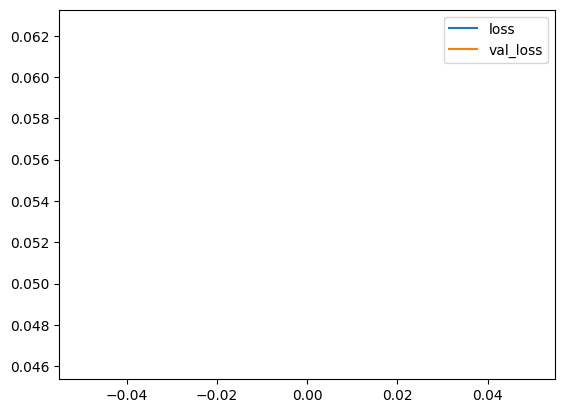

In [59]:
plt.figure(figsize=(15, 10), dpi=120)

pd.DataFrame(history.history).plot()

plt.show()